In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
from nilmtk import DataSet

In [158]:
data = DataSet('./iawe.h5').buildings[1].elec

In [159]:
mains = next(data.mains().load())

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.


In [160]:
ac = next(data['air conditioner'].load())[('power','active')]
wm = next(data['washing machine'].load())[('power','active')]
fr = next(data['fridge'].load())[('power','active')]
cp = next(data['computer'].load())[('power','active')]
ir = next(data['clothes iron'].load())[('power','active')]
tv = next(data['television'].load())[('power','active')]
mo = next(data['motor'].load())[('power','active')]

In [161]:
appliances = [ac , wm , fr , cp , ir , tv , mo]

In [162]:
def preprocess(li_df):
    li = []
    for df in li_df:
        df = scipy.signal.medfilt(df, kernel_size=None)
        li.append(df)
    return li

In [163]:
appliances = preprocess(appliances)

In [164]:
ac = appliances[0]
wm = appliances[1]
fr = appliances[2]
cp = appliances[3]
ir = appliances[4]
tv = appliances[5]
mo = appliances[6]

In [165]:
mains = mains[('power','active')]

In [166]:
mains = scipy.signal.medfilt(mains, kernel_size=None)

In [359]:
SIG_SIZE = 6
THRSHLD = 50

In [366]:
#using stft to find edges
def edge_detection(device):
    f,t,Zxx = scipy.signal.stft(device, fs=1.0, window='hamming', nperseg=10, 
                                noverlap=None, nfft=None, detrend=False, 
                                return_onesided=True, boundary='zeros', 
                                padded=True, axis=- 1)
    t = t.astype('int')
    
    return t

In [367]:
#using gradient to find edges
def edge_detection2(device): 
    on_events = []
    dbydx = np.gradient(device)
    max_val = 0
    for idx,x in enumerate(dbydx):
        if x > (max_val + THRSHLD):
            on_events.append(idx)
            max_val = x
        else:
            max_val = x
#             mean = np.mean(device[:x])
    return on_events

In [372]:
db = [] #signature database
prev_len = 0
name_db = []

In [373]:
def grab_on_sig(edges,device,db):
    df = []
    for x in edges:
        if x in range(SIG_SIZE):
            pass
        elif x >= len(device)-SIG_SIZE:
            pass
        elif np.mean(device[x:x+SIG_SIZE])>np.mean(device[x-SIG_SIZE:x]+THRSHLD) and device[(x-1)]<THRSHLD: #device consuming more than 20kWh
            df.append(device[x:x+SIG_SIZE])
            db.append(df)
            df=[]
        else:
            pass
    return db

In [374]:
edges = edge_detection2(ac) 
db = grab_on_sig(edges,ac,db)

In [375]:
l = len(db)
print(l)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('wm')

18


In [376]:
edges = edge_detection2(wm) 
db = grab_on_sig(edges,wm,db)

In [377]:
l = len(db)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('wm')

In [378]:
l

39

In [379]:
edges = edge_detection2(fr) 
db = grab_on_sig(edges,fr,db)

In [380]:
l = len(db)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('fr')

In [381]:
l

1260

In [382]:
edges = edge_detection2(cp) 
db = grab_on_sig(edges,cp,db)

In [383]:
l = len(db)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('cp')

In [384]:
l

1260

In [385]:
edges = edge_detection2(ir) 
db = grab_on_sig(edges,ir,db)

In [386]:
l = len(db)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('ir')

In [387]:
l

1347

In [388]:
edges = edge_detection2(mo) 
db = grab_on_sig(edges,mo,db)

In [389]:
l = len(db)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('mo')

In [390]:
l

1405

In [391]:
len(db),len(name_db)

(1405, 1405)

In [392]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [393]:
db = np.array(db)

In [394]:
db = db.reshape((l,SIG_SIZE))

In [395]:
db.shape

(1405, 6)

In [396]:
X = db

y = name_db

In [397]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [398]:
clf = RandomForestClassifier()

In [399]:
clf.fit(X_train,y_train)

RandomForestClassifier()

In [400]:
preds = clf.predict(X_test)==y_test

In [401]:
print(f'Total number of predictions = {preds.size}\n',
      f'Number of {np.unique(preds,return_counts=True)[0][0]} predictions = {np.unique(preds,return_counts=True)[1][0]}\n',
      f'Number of {np.unique(preds,return_counts=True)[0][1]} predictions= {np.unique(preds,return_counts=True)[1][1]}\n',
      f'Accuracy = {(np.unique(preds,return_counts=True)[1][1])/(preds.size)*100:.2f}%')

Total number of predictions = 281
 Number of False predictions = 1
 Number of True predictions= 280
 Accuracy = 99.64%


In [402]:
def on_off_decision(edges,device):
    on_events = []
    off_events = []
    for x in edges:
        if x in range(SIG_SIZE) or x >= edges[-1]-SIG_SIZE :
            pass
        else:
            if np.mean(device[x:x+SIG_SIZE])>np.mean(device[x-SIG_SIZE:x]+THRSHLD): #device consuming more than 5kWh
                on_events.append(x)
            elif np.mean(device[x:x+SIG_SIZE])<np.mean(device[x-SIG_SIZE:x]-THRSHLD):
                off_events.append(x)
            else:
                pass
    return on_events

In [409]:
e= edge_detection2(mains) # returns indexes 

In [410]:
e

[9,
 15,
 109,
 179,
 180,
 182,
 211,
 261,
 309,
 331,
 354,
 355,
 371,
 403,
 404,
 421,
 709,
 731]

In [431]:
dbmains = []

In [432]:
def grab_on_mains(edges,device,db):
    df = []
    for x in edges:
        df.append(device[x:x+SIG_SIZE])
        db.append(df)
        df=[]
    return db

In [433]:
dbmains = grab_on_mains(e,mains,dbmains)

In [434]:
l  = len(dbmains)

In [435]:
l

18

In [436]:
dbmains = np.array(dbmains).reshape((l,SIG_SIZE))

In [437]:
clf.predict(dbmains)

array(['wm', 'mo', 'ir', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm',
       'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm'], dtype='<U2')

In [438]:
main_preds = clf.predict(dbmains)

In [327]:
main_preds = clf.predict_proba(dbmains)

In [338]:
main_preds = main_preds*100

In [341]:
main_preds = main_preds.astype(int)

In [340]:
np.max(main_preds[0]).astype(int)

51

In [344]:
z = np.where(np.max(x)<80 for x in main_preds)

In [349]:
np.max(main_preds[0])

51

In [440]:
df = pd.DataFrame({'idx':e, 'preds':main_preds})

In [326]:
df,ev

(    idx preds
 0    10    ir
 1   105    mo
 2   110    ir
 3   115    ir
 4   175    ir
 5   180    wm
 6   185    wm
 7   310    wm
 8   330    wm
 9   335    wm
 10  370    wm
 11  375    wm
 12  405    wm
 13  410    wm
 14  705    wm
 15  710    wm
 16  715    wm,
 {'10': 'ac, tv',
  '100': 'wm',
  '150': 'fr',
  '300': 'computer',
  '310': 'iron',
  '700': 'motor'})

# **make dummy mains**

ac , wm , fr , cp , ir , tv , mo

In [403]:
ac_test = ac[:1000]
wm_test = wm[:1000]
fr_test = fr[:1000]
cp_test = cp[:1000]
ir_test = ir[:1000]
tv_test = tv[:1000]
mo_test = mo[:1000]

In [404]:
ac_test[100:200] += wm_test[100:200]
ac_test[150:250] += fr_test[150:250]
ac_test[300:400] += cp_test[300:400]
ac_test[310:410] += ir_test[310:410]
ac_test[:200] += tv_test[:200]
ac_test[700:800] += mo_test[700:800]

In [405]:
mains = ac_test

In [406]:
for x in range(10):
    mains = np.insert(mains,0,0)

In [407]:
ev = {'10':'ac, tv',
      '100': 'wm',
     '150':'fr',
     '300': 'computer',
     '310':'iron',
     '700':'motor'}

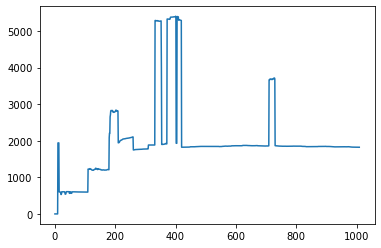

In [408]:
plt.plot(mains)